In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch

# 1. Upload the dataset
from google.colab import files
uploaded = files.upload()

# 2. Load the dataset into DataFrame
df = pd.read_csv('single_genre_artists.csv')

# 3. Explore the dataset
print("--- Dataset Info ---")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Shape ---")
print(df.shape)

# 4. Preview data
df.head()


Saving single_genre_artists.csv to single_genre_artists (1).csv
--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness 

,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,...,0.993,0.000016,0.325,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,...,0.989,0.000000,0.128,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,...,0.995,0.000000,0.418,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,...,0.991,0.000000,0.219,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,...,0.991,0.000000,0.373,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22


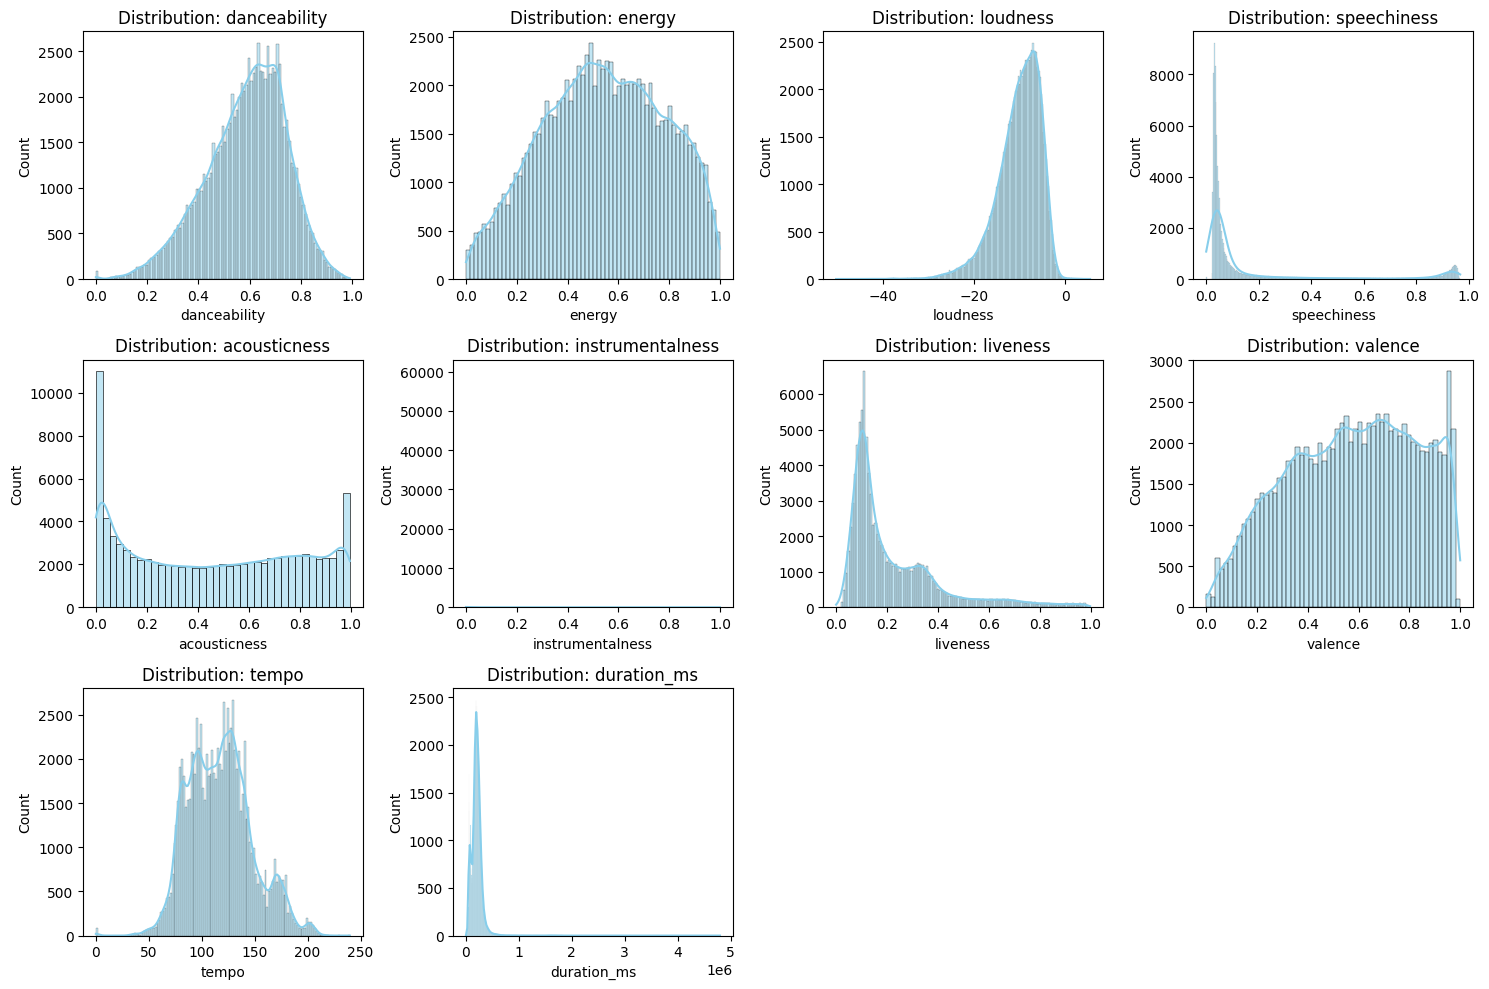

Data normalized and features selected.


In [4]:
# 1. Select the recommended features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# 2. Visualize distributions before scaling (Requirement 1.4)
plt.figure(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

# 3. Create feature matrix and handle IDs (Requirement 1.3)
# We keep 'df' for final export but use 'X' for the model
X = df[features].copy()
X = X.fillna(X.mean()) # Fill any missing values with mean

# 4. Normalize the data (Requirement 1.5)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data normalized and features selected.")

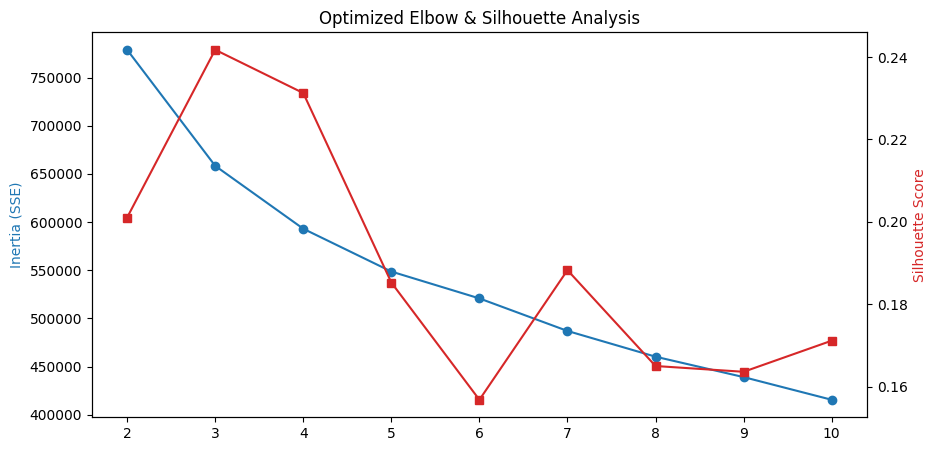

In [7]:
inertia = []
sil_scores = []
K_range = range(2, 11)

# Optimization: Sample the data if it's too large (e.g., > 10,000 rows)
# This speeds up the Silhouette calculation significantly
if len(X_scaled) > 5000:
    sample_indices = np.random.choice(len(X_scaled), 5000, replace=False)
    X_eval = X_scaled[sample_indices]
else:
    X_eval = X_scaled

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled) # Still fit on all data

    # Inertia is fast, so we use full data
    inertia.append(km.inertia_)

    # Silhouette is slow, so we use the sample
    sample_labels = labels[sample_indices] if len(X_scaled) > 5000 else labels
    sil_scores.append(silhouette_score(X_eval, sample_labels))

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(K_range, inertia, marker='o', color='tab:blue')
ax1.set_ylabel('Inertia (SSE)', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, marker='s', color='tab:red')
ax2.set_ylabel('Silhouette Score', color='tab:red')
plt.title('Optimized Elbow & Silhouette Analysis')
plt.show()

In [11]:
# 4. Quick View of results (Safe Version)
# List of potential name columns to show alongside the cluster
metadata_cols = ['track_name', 'artist_name', 'Title', 'Artist', 'song_title']
available_metadata = [col for col in metadata_cols if col in df.columns]

for i in range(optimal_k):
    print(f"\n--- Top 3 tracks in Cluster {i} ---")
    cluster_data = df[df['KMeans_Cluster'] == i]

    if available_metadata:
        # Print with names if they exist
        print(cluster_data[available_metadata].head(3))
    else:
        # If no name columns exist, just show the first few rows of features
        print("No name columns found. Showing feature slice:")
        print(cluster_data[features].head(3))


--- Top 3 tracks in Cluster 0 ---
No name columns found. Showing feature slice:
    danceability  energy  loudness  speechiness  acousticness  \
15         0.760   0.366   -10.173       0.0650         0.939   
34         0.650   0.520   -12.068       0.0817         0.953   
38         0.769   0.442   -12.697       0.2730         0.989   

    instrumentalness  liveness  valence    tempo  duration_ms  
15          0.000000    0.4070    0.846  129.074       140867  
34          0.000000    0.0629    0.888  131.367       185973  
38          0.000001    0.1670    0.934  132.125       140267  

--- Top 3 tracks in Cluster 1 ---
No name columns found. Showing feature slice:
    danceability  energy  loudness  speechiness  acousticness  \
53         0.625   0.295   -15.430       0.2450         0.834   
65         0.621   0.274   -12.094       0.0514         0.986   
67         0.733   0.418   -12.287       0.0765         0.949   

    instrumentalness  liveness  valence    tempo  duration_m

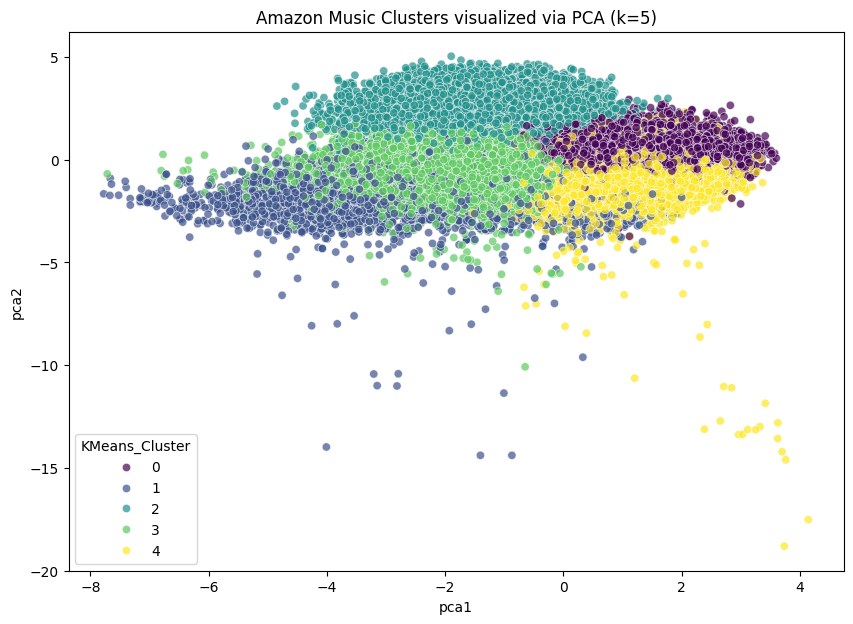

--- Evaluation Metrics ---
Silhouette Score: 0.1864 (Higher is better)
Davies-Bouldin Index: 1.6888 (Lower is better)
Inertia: 548594.92


In [9]:
# 1. Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
df['pca1'] = pca_data[:, 0]
df['pca2'] = pca_data[:, 1]

# 2. Scatter Plot of Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='KMeans_Cluster', palette='viridis', alpha=0.7)
plt.title(f'Amazon Music Clusters visualized via PCA (k={optimal_k})')
plt.show()

# 3. Metrics (Requirement 5.1)
sil_final = silhouette_score(X_scaled, df['KMeans_Cluster'])
db_index = davies_bouldin_score(X_scaled, df['KMeans_Cluster'])

print(f"--- Evaluation Metrics ---")
print(f"Silhouette Score: {sil_final:.4f} (Higher is better)")
print(f"Davies-Bouldin Index: {db_index:.4f} (Lower is better)")
print(f"Inertia: {kmeans.inertia_:.2f}")

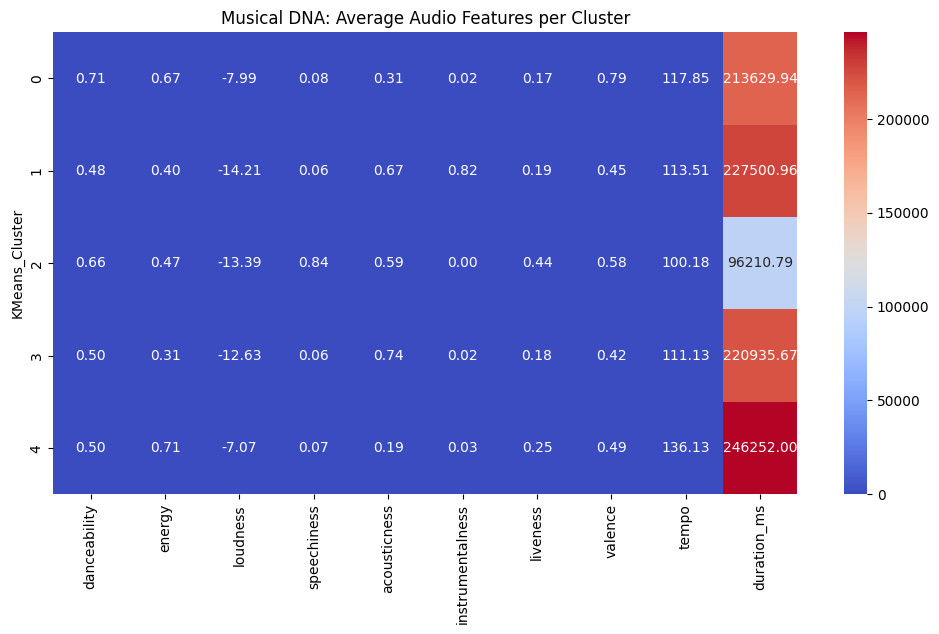

✅ Success: 'amazon_music_final_clusters.csv' has been exported.

--- Cluster 0 Representative Tracks ---
    danceability  energy  loudness  speechiness  acousticness  \
15         0.760   0.366   -10.173       0.0650         0.939   
34         0.650   0.520   -12.068       0.0817         0.953   
38         0.769   0.442   -12.697       0.2730         0.989   

    instrumentalness  liveness  valence    tempo  duration_ms  
15          0.000000    0.4070    0.846  129.074       140867  
34          0.000000    0.0629    0.888  131.367       185973  
38          0.000001    0.1670    0.934  132.125       140267  

--- Cluster 1 Representative Tracks ---
    danceability  energy  loudness  speechiness  acousticness  \
53         0.625   0.295   -15.430       0.2450         0.834   
65         0.621   0.274   -12.094       0.0514         0.986   
67         0.733   0.418   -12.287       0.0765         0.949   

    instrumentalness  liveness  valence    tempo  duration_ms  
53          

In [12]:
# --- PHASE 7: INTERPRETATION & EXPORT ---

# 1. Cluster Profiling (Requirement 5.2)
# This calculates the "Average" song for each group
cluster_profile = df.groupby('KMeans_Cluster')[features].mean()

# 2. Heatmap for Interpretation (Requirement 6.3)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Musical DNA: Average Audio Features per Cluster')
plt.show()


# 3. Final Export (Requirement 7.3)
df.to_csv('amazon_music_final_clusters.csv', index=False)
print("✅ Success: 'amazon_music_final_clusters.csv' has been exported.")

# 4. Quick View of Results (Error-Proof Version)
# We look for ANY column that might be a name/title
possible_names = ['track_name', 'artist_name', 'title', 'artist', 'song', 'name']
found_names = [c for c in df.columns if c.lower() in possible_names]

for i in range(optimal_k):
    print(f"\n--- Cluster {i} Representative Tracks ---")
    cluster_subset = df[df['KMeans_Cluster'] == i]

    if found_names:
        # If names exist, show them
        print(cluster_subset[found_names].head(3))
    else:
        # If names were dropped, show the first few features so you can still see the data
        print(cluster_subset[features].head(3))

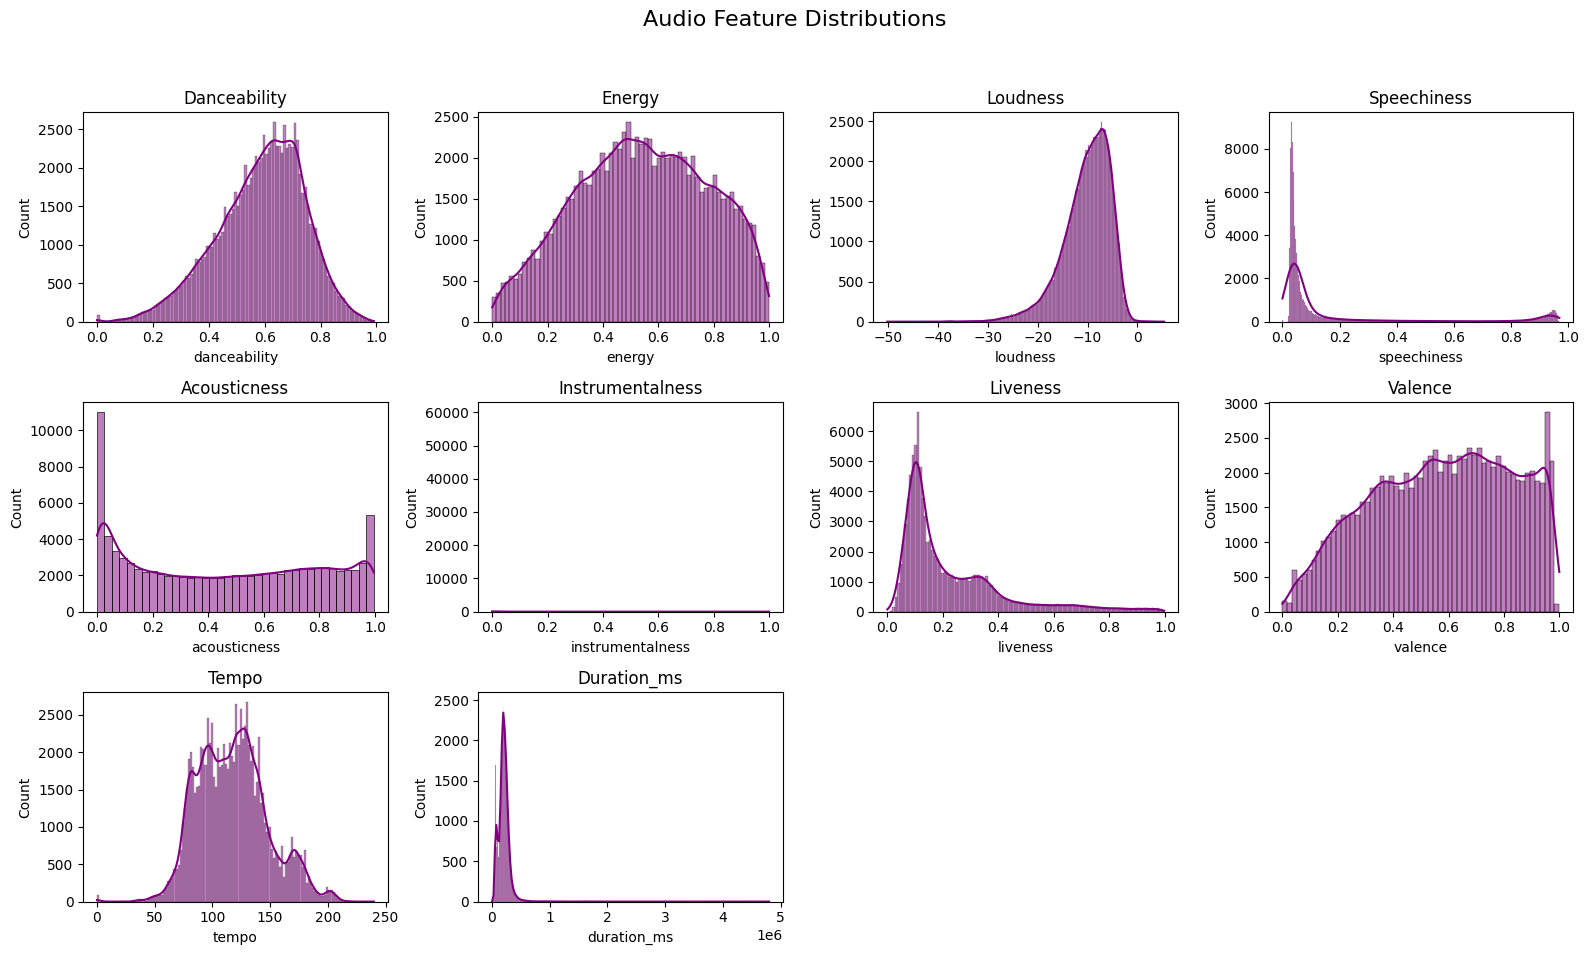

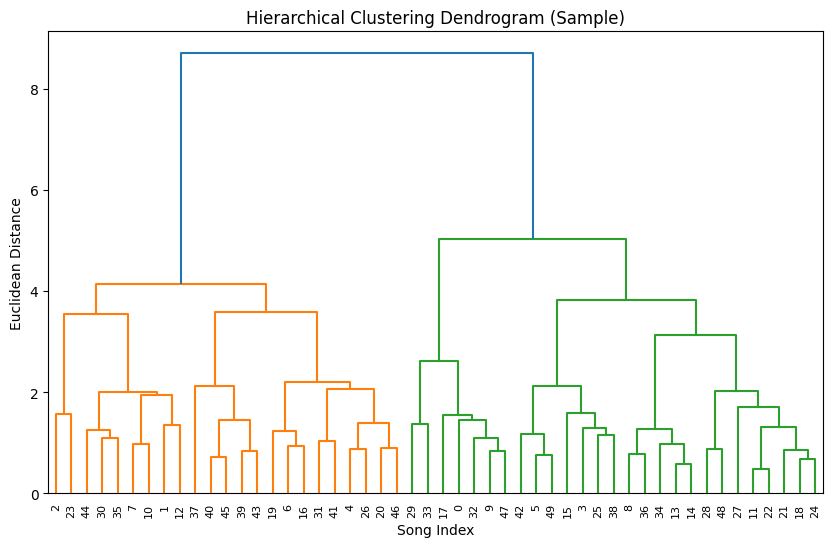

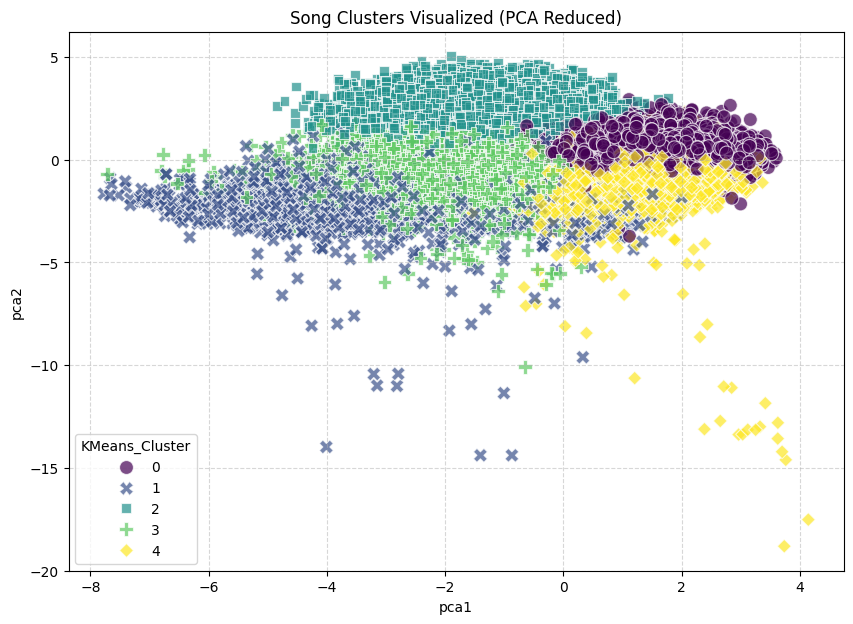

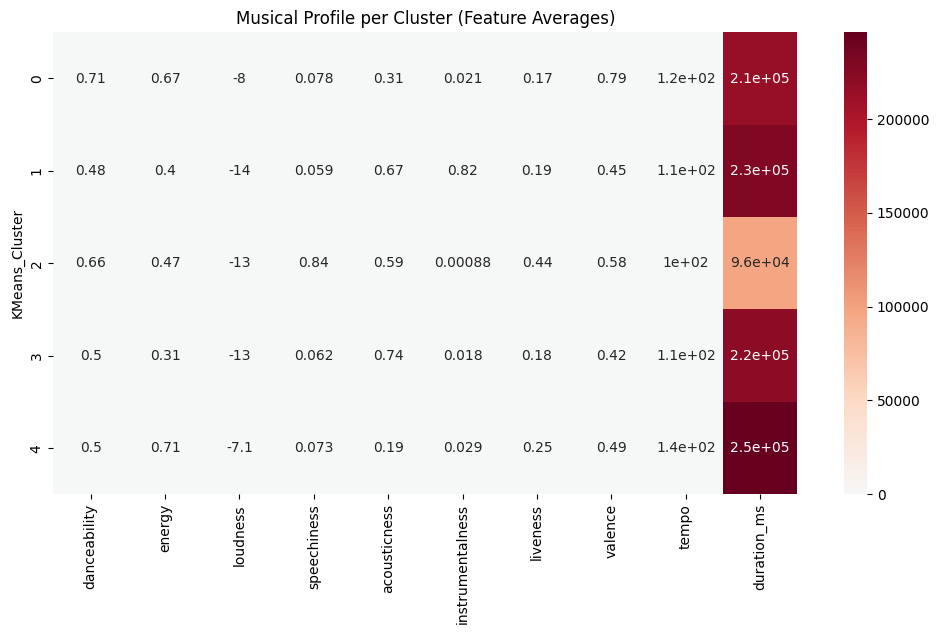

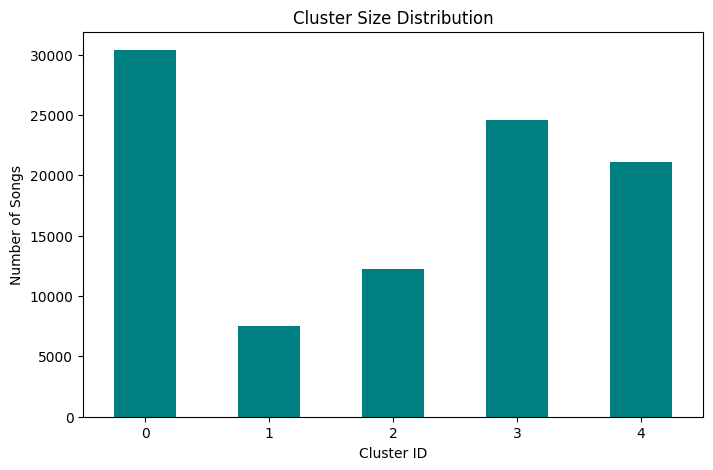

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Distribution Plots (Phase 1 & 6) ---
# Goal: Understand the variation of each audio feature
plt.figure(figsize=(16, 10))
plt.suptitle("Audio Feature Distributions", fontsize=16)
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True, color='purple')
    plt.title(f'{col.capitalize()}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 2. Hierarchical Clustering Dendrogram (Phase 4 & 6) ---
# Goal: Visualize the "tree" of how songs merge into groups
plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram (Sample)")
# Linkage calculates the distance; Dendrogram plots it
dendrogram = sch.dendrogram(sch.linkage(X_scaled[:50], method='ward'))
plt.xlabel("Song Index")
plt.ylabel("Euclidean Distance")
plt.show()


# --- 3. 2D Cluster Visualization via PCA (Phase 3 & 6) ---
# Goal: See how well K-Means separated the songs in a 2D space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='KMeans_Cluster',
                palette='viridis', style='KMeans_Cluster', s=100, alpha=0.7)
plt.title("Song Clusters Visualized (PCA Reduced)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# --- 4. Cluster Profile Heatmap (Phase 5 & 6) ---
# Goal: Interpret what each cluster "sounds" like
cluster_profile = df.groupby('KMeans_Cluster')[features].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile, annot=True, cmap='RdBu_r', center=0)
plt.title("Musical Profile per Cluster (Feature Averages)")
plt.show()


# --- 5. Cluster Size Balance (Metric Requirement) ---
# Goal: Check if clusters are evenly distributed
plt.figure(figsize=(8, 5))
df['KMeans_Cluster'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Songs")
plt.xticks(rotation=0)
plt.show()

In [14]:
def get_recommendations(song_title, num_rec=5):
    if song_title not in df['track_name'].values:
        return "Song not found."

    cluster_id = df[df['track_name'] == song_title]['KMeans_Cluster'].values[0]
    recs = df[df['KMeans_Cluster'] == cluster_id].sample(num_rec + 1)
    return recs[recs['track_name'] != song_title][['track_name', 'artist_name']]

# Test it:
# print(get_recommendations('Insert a song name from your CSV here'))